<a href="https://colab.research.google.com/github/soobook/TensorFlow-DL/blob/main/code/TF18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 18회차: DNN-GAN을 활용한 손글씨 모방하기 (4) - 모델 최적화

### 데이터 시각화 한글 준비와 선명도 설정

In [ ]:
# 시각화 준비
!pip install koreanize_matplotlib
import koreanize_matplotlib
%config InlineBackend.figure_format = 'retina'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 51.8 MB/s eta 0:00:00


### leaky_relu() 함수 데이터 시각화

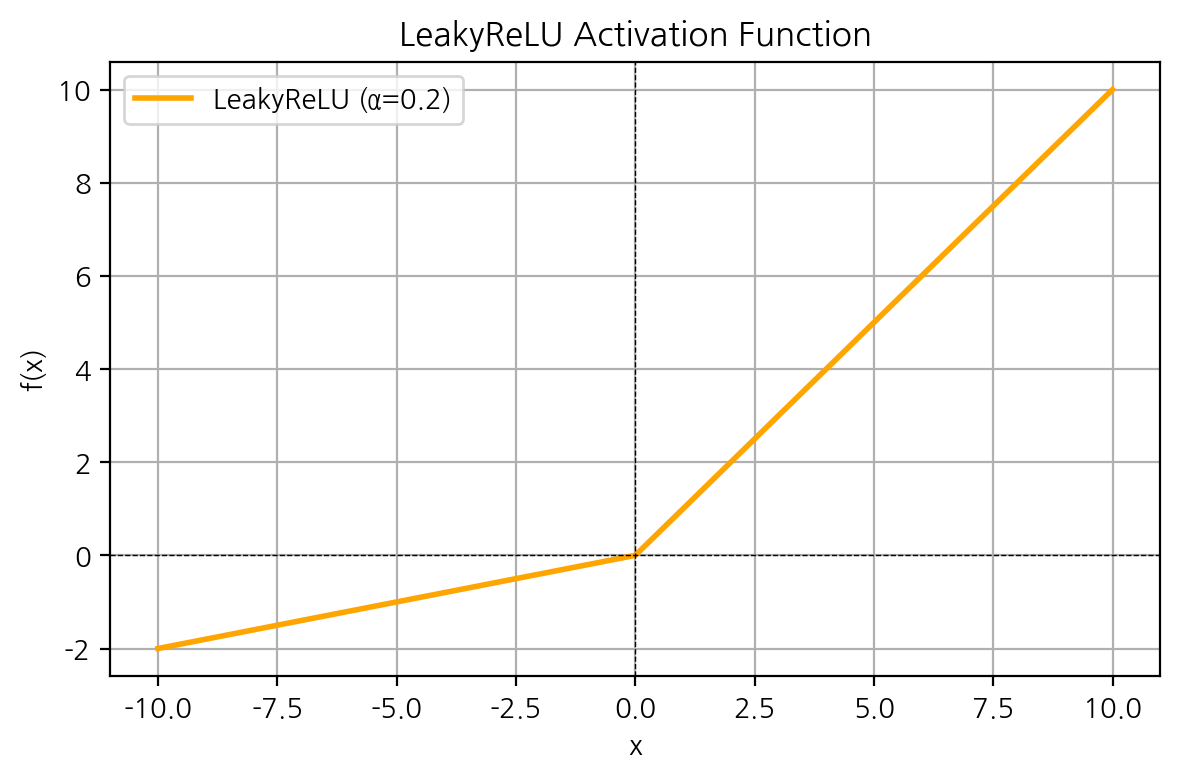

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# LeakyReLU 정의
def leaky_relu(x, alpha=0.2):
    return np.where(x >= 0, x, alpha * x)

# x 범위 설정
x = np.linspace(-10, 10, 1000)
y = leaky_relu(x)

# 그래프 그리기
plt.figure(figsize=(6, 4))
plt.plot(x, y, label="LeakyReLU (α=0.2)", color="orange", linewidth=2)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.title("LeakyReLU Activation Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### relu()와 leaky_relu() 함수 데이터 시각화

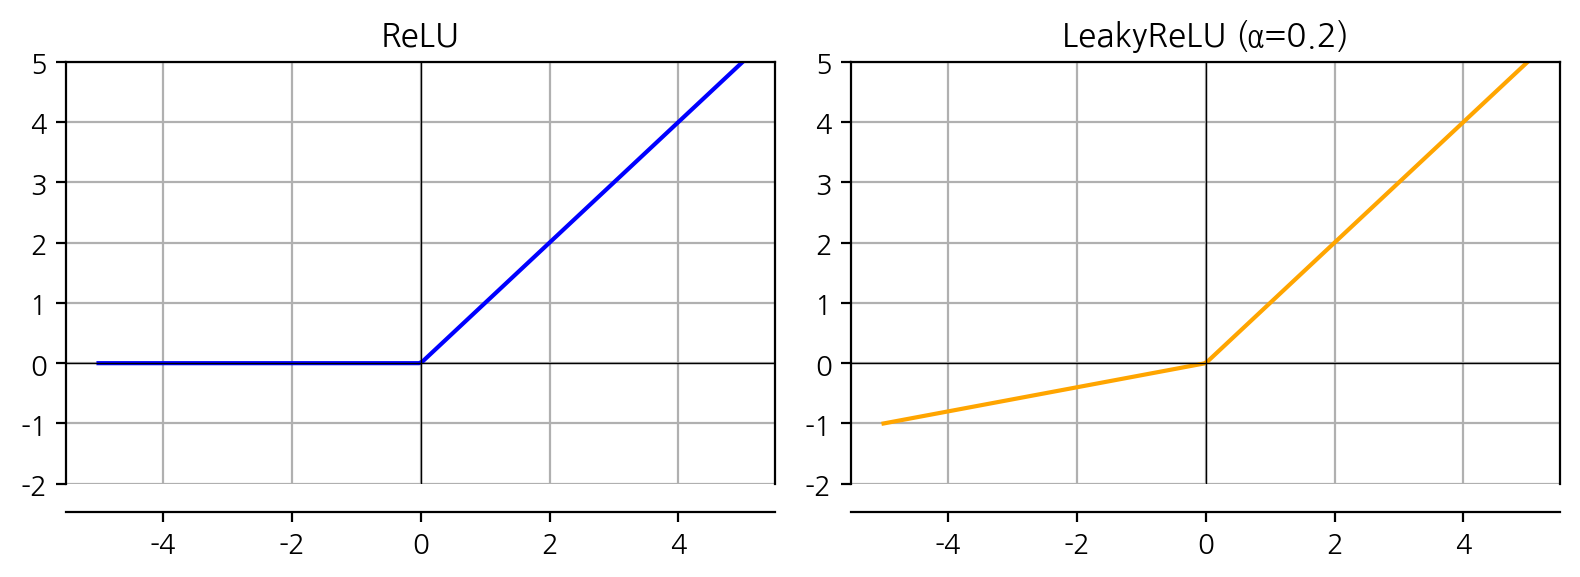

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 입력값 정의
x = np.linspace(-5, 5, 200)
# ReLU 및 LeakyReLU 함수 정의
relu = np.maximum(0, x)
leaky_relu = np.where(x > 0, x, 0.2 * x)

# y축 범위 및 눈금
ymin, ymax = -2, 5
yticks = np.arange(-2, 6, 1)
# 그래프 생성
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

# ReLU 시각화
axs[0].plot(x, relu, color='blue')
axs[0].set_title("ReLU")
axs[0].set_ylim(ymin, ymax)
axs[0].set_yticks(yticks)
axs[0].spines['bottom'].set_position(('outward', 10))
axs[0].axhline(0, color='black', linewidth=0.5)
axs[0].axvline(0, color='black', linewidth=0.5)
axs[0].grid(True)

# LeakyReLU 시각화
axs[1].plot(x, leaky_relu, color='orange')
axs[1].set_title("LeakyReLU (α=0.2)")
axs[1].set_ylim(ymin, ymax)
axs[1].set_yticks(yticks)
axs[1].spines['bottom'].set_position(('outward', 10))
axs[1].axhline(0, color='black', linewidth=0.5)
axs[1].axvline(0, color='black', linewidth=0.5)
axs[1].grid(True)

plt.tight_layout()
plt.show()

## 최적화된 DNN-GAN 구현

In [ ]:
# -------------------- 1. 라이브러리 로딩 --------------------
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
import tensorflow_probability as tfp

# -------------------- 2. 데이터 준비 및 증강 --------------------
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype("float32") - 127.5) / 127.5
x_train = x_train.reshape((-1, 784))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# -----------------------  모델 최적화 4 --------------------------------------
# -----------------------  데이터 증강 ----------------------------------------
def augment_images(images):
    # 원래 (batch, 784) 형태인 데이터를 (batch, 28, 28, 1)로 바꿈
    images = tf.reshape(images, (-1, 28, 28, 1))

    # 밝기 약하게 증강, 픽셀 값이 -0.1 ~ +0.1만큼 변경
    images = tf.image.random_brightness(images, max_delta=0.1)
    # 명암 대비 약하게 증강, 원래 명암의 90% ~ 110% 사이에서 무작위로 변화
    images = tf.image.random_contrast(images, 0.9, 1.1)
    # 픽셀값 정규화 범위 유지 (-1 ~ 1로 가정)
    images = tf.clip_by_value(images, -1.0, 1.0)

    # 다시 784차원 벡터(flattened)로 복원
    return tf.reshape(images, (-1, 784))

BUFFER_SIZE = 60000
BATCH_SIZE = 128
train_dataset = (
    tf.data.Dataset.from_tensor_slices(x_train)  # 텐서에서 Dataset 생성
    .map(augment_images)                         # 이미지 증강 적용
    .shuffle(BUFFER_SIZE)                        # 데이터 순서 무작위화
    .batch(BATCH_SIZE)                           # 미니배치 구성
)

In [ ]:
# -------------------- 3. Generator / Discriminator 정의 --------------------
# -----------------------  모델 최적화 3 --------------------------------------
# 생성자 구조 최적화
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Input(shape=(100,)),
        layers.Dense(128), layers.LeakyReLU(), # 기본값 alpha=0.3
        layers.BatchNormalization(),
        layers.Dense(256), layers.LeakyReLU(),
        layers.BatchNormalization(),
        layers.Dense(512), layers.LeakyReLU(),
        layers.BatchNormalization(),
        layers.Dense(784, activation='tanh')
    ])
    return model

# 판별자 구조 최적화
def make_discriminator_model():
    return tf.keras.Sequential([
        layers.Input(shape=(784,)),
        layers.Dense(512), layers.LeakyReLU(0.2),
        layers.Dense(256), layers.LeakyReLU(0.2),
        layers.Dense(1), layers.Activation('sigmoid')
    ])

In [ ]:
tf.ones_like(np.array([1., 2., 3.])) * 0.9

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.9, 0.9, 0.9])>

In [ ]:
# -------------------- 4. GAN 클래스 정의 --------------------
class GAN(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.feature_layer = layers.Dense(128, activation='relu')  # Feature Matching 용

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super().compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        real_images = tf.reshape(real_images, [-1, 784])  # ← 여기 추가!
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal([batch_size, 100])  # 다양한 z seed 사용

        # Discriminator 학습
        with tf.GradientTape() as tape:
            fake_images = self.generator(noise)
            real_logits = self.discriminator(real_images)
            fake_logits = self.discriminator(fake_images)

            # -----------------------  모델 최적화 1 --------------------------------------
            # 라벨 스무딩(Label Smoothing): 진짜 이미지에 대해 1.0 대신 0.9 사용
            d_loss_real = self.loss_fn(tf.ones_like(real_logits) * 0.9, real_logits)
            d_loss_fake = self.loss_fn(tf.zeros_like(fake_logits), fake_logits)
            d_loss = (d_loss_real + d_loss_fake) / 2
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Generator 학습
        noise = tf.random.normal([batch_size, 100])
        with tf.GradientTape() as tape:
          fake_images = self.generator(noise)
          fake_logits = self.discriminator(fake_images)

          # -----------------------  모델 최적화 2 --------------------------------------
          # 특징 정합 손실(Feature Matching Loss):
          # 판별자의 중간 특징 벡터(feature vector) 평균 차이를 생성자의의 손실로 사용
          # (1) 기본 생성자 손실(Adversarial loss)
          adv_loss = self.loss_fn(tf.ones_like(fake_logits), fake_logits)
          # (2) 특징 정합 손실(Feature Matching loss)
          # 실제(real) 이미지의 특성(feature)을 추출함
          real_features = self.feature_layer(real_images)
          # 가짜(fake, 생성된) 이미지의 특성을 추출함
          fake_features = self.feature_layer(fake_images)
          # 실제와 가짜 이미지의 평균 특성 간 차이를 계산하여 Feature Matching Loss를 구함
          # 특징 정합 손실은 생성자가 실제 데이터의 분포적 특징을 학습하도록 유도
          feature_loss = tf.reduce_mean(tf.square(tf.reduce_mean(real_features, axis=0) -
                                                  tf.reduce_mean(fake_features, axis=0)))
          # (3) Total Generator loss = adversarial + feature matching
          g_loss = adv_loss + 10.0 * feature_loss  # λ=10.0

        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

In [ ]:
# -------------------- 5. FID / IS 계산 --------------------
inception = InceptionV3(include_top=False, pooling='avg', input_shape=(75, 75, 3))

def get_inception_features(images):
    # (B, 784) 형태일 경우 → (B, 28, 28, 1)로 복원
    if images.shape.rank == 2 and images.shape[1] == 784:
        images = tf.reshape(images, [-1, 28, 28, 1])

    # (B, 28, 28) 형태일 경우 → 채널 추가
    elif images.shape.rank == 3:
        images = tf.expand_dims(images, axis=-1)

    # 마지막 차원이 1이면 흑백 → RGB 변환
    if images.shape[-1] == 1:
        images = tf.image.grayscale_to_rgb(images)

    # 마지막 차원이 3이 아니면 예외 (예: 채널 수 이상함)
    elif images.shape[-1] != 3:
        raise ValueError(f"Expected channel dimension of 1 or 3, got shape: {images.shape}")

    # 크기 맞추기 (InceptionV3는 최소 75x75 이상 필요)
    images = tf.image.resize(images, [75, 75])

    # [-1, 1] 정규화된 이미지라면 → [0, 255]로 변환
    images = (images + 1.0) * 127.5

    # InceptionV3에 맞는 전처리
    images = preprocess_input(images)

    # InceptionV3를 통해 feature 추출
    return inception(images, training=False)

def calculate_fid(real_images, fake_images):
    # InceptionV3 특성 추출
    act1 = get_inception_features(real_images)
    act2 = get_inception_features(fake_images)

    # 평균 및 공분산 계산
    mu1, sigma1 = tf.reduce_mean(act1, axis=0), tfp.stats.covariance(act1)
    mu2, sigma2 = tf.reduce_mean(act2, axis=0), tfp.stats.covariance(act2)
    # 평균 차이의 제곱합 (Euclidean 거리)
    ssdiff = tf.reduce_sum(tf.square(mu1 - mu2))

    # 수치 안정성을 위해 아주 작은 값 더하기
    eps = 1e-6
    sigma1 += eps * tf.eye(sigma1.shape[0])
    sigma2 += eps * tf.eye(sigma2.shape[0])
    # 행렬 곱의 제곱근 계산
    covmean = sqrtm((sigma1 @ sigma2).numpy())
    # 복소수 값이 나올 경우 실수 부분만 사용
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # FID 계산: 평균 거리 + 공분산 trace 거리
    fid = ssdiff + tf.linalg.trace(sigma1 + sigma2 - 2 * tf.convert_to_tensor(covmean))

    return fid

def calculate_inception_score(images, splits=10):
    preds = tf.nn.softmax(get_inception_features(images))
    scores = []
    N = preds.shape[0]
    for i in range(splits):
        part = preds[i * N // splits: (i + 1) * N // splits]
        py = tf.reduce_mean(part, axis=0)
        kl = part * (tf.math.log(part + 1e-10) - tf.math.log(py + 1e-10))
        kl_sum = tf.reduce_mean(tf.reduce_sum(kl, axis=1))
        scores.append(tf.exp(kl_sum).numpy())
    return np.mean(scores)

# -------------------- 6. 5 에폭마다 생성된 이미지 저장 함수 --------------------
def generate_and_save_images(model, epoch, seed):
    # 고정된 latent seed로 Generator에서 이미지 생성
    predictions = model(seed, training=False)
    # 생성 이미지의 픽셀값을 [-1, 1] → [0, 1] 범위로 정규화 (시각화용)
    predictions = (predictions + 1) / 2.0

    # 4x4 그리드 형태의 이미지 출력을 위한 figure 객체 생성
    fig = plt.figure(figsize=(4, 4))
    # 생성된 각 이미지를 서브플롯에 하나씩 출력
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)  # 4행 4열 중 i+1 번째 위치에 이미지 배치
        # 28x28 이미지로 reshape, 흑백 표시
        plt.imshow(predictions[i].numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')  # 축 눈금 숨기기

    # 저장 폴더가 없으면 생성
    os.makedirs("generated", exist_ok=True)
    # 이미지 저장: 에폭 번호를 네 자리로 표현하여 파일 이름 지정
    plt.savefig(f"generated/image_epoch_{epoch:04d}.png")
    # 현재 figure 객체 닫기 (메모리 누수 방지)
    plt.close()

# -------------------- 7. 콜백 정의 --------------------
class ImageEvalCallback(tf.keras.callbacks.Callback):
    def __init__(self, generator, seed, real_images):
        # 생성된 이미지를 평가할 Generator 모델
        self.generator = generator
        # 고정된 노이즈 벡터 (이미지 생성 consistency 확보용)
        self.seed = seed
        # 실제 이미지 샘플 (FID 계산 시 사용)
        self.real_images = real_images
        # 에폭별 FID 점수를 저장할 리스트
        self.fid_scores = []
        # 에폭별 IS (Inception Score)를 저장할 리스트
        self.is_scores = []
        # 에폭 단위 Discriminator 손실값 저장 리스트
        self.epoch_d_losses = []
        # 에폭 단위 Generator 손실값 저장 리스트
        self.epoch_g_losses = []
        # 현재 에폭에서 배치마다 누적되는 Discriminator 손실 (평균 내기 위함)
        self._temp_d_losses = []
        # 현재 에폭에서 배치마다 누적되는 Generator 손실 (평균 내기 위함)
        self._temp_g_losses = []

    # 각 배치 학습이 끝날 때 호출되는 콜백 함수
    def on_train_batch_end(self, batch, logs=None):
        if logs:
            # 이번 배치의 Discriminator 손실값을 임시 리스트에 저장
            self._temp_d_losses.append(logs["d_loss"])
            # 이번 배치의 Generator 손실값을 임시 리스트에 저장
            self._temp_g_losses.append(logs["g_loss"])

    # 한 에폭 학습이 끝날 때 호출되는 콜백 함수
    def on_epoch_end(self, epoch, logs=None):
        # 현재 에폭에서 누적된 배치 손실값들의 평균 계산
        mean_d = np.mean(self._temp_d_losses)
        mean_g = np.mean(self._temp_g_losses)

        # 에폭 단위로 평균 손실을 저장
        self.epoch_d_losses.append(mean_d)
        self.epoch_g_losses.append(mean_g)

        # 다음 에폭을 위한 임시 손실 리스트 초기화
        self._temp_d_losses.clear()
        self._temp_g_losses.clear()

        # 5 에폭마다 이미지 생성 및 평가 수행
        if (epoch + 1) % 5 == 0:
            # 이미지 생성 및 저장
            generate_and_save_images(self.generator, epoch + 1, self.seed)

            # 생성된 이미지와 실제 이미지로 FID 및 IS 계산
            fake_images = self.generator(self.seed, training=False)
            real_sample = tf.convert_to_tensor(self.real_images[:16])
            # 흑백 이미지를 RGB로 변환 (Inception 입력용)
            real_rgb = tf.image.grayscale_to_rgb(tf.reshape(real_sample, [-1, 28, 28, 1]))
            fake_rgb = tf.image.grayscale_to_rgb(tf.reshape((fake_images + 1) / 2.0, [-1, 28, 28, 1]))
            # FID 계산
            fid = calculate_fid(real_rgb, fake_rgb).numpy()
            # IS 계산
            inc = calculate_inception_score(fake_rgb)

            # 평가 점수 저장
            self.fid_scores.append(fid)
            self.is_scores.append(inc)

            # 콘솔에 점수 출력
            print(f"\nEpoch {epoch+1} - FID: {fid:.2f} | IS: {inc:.2f}")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# -------------------- 8. 훈련 --------------------
# 생성자 모델 인스턴스 생성
generator = make_generator_model()
# 판별자 모델 인스턴스 생성
discriminator = make_discriminator_model()

# GAN 모델을 생성자와 판별자로 구성하여 상속된 모델 정의
gan = GAN(generator, discriminator)
# GAN 모델 컴파일: 생성자와 판별자 각각의 옵티마이저와 손실 함수 설정
gan.compile(
    g_optimizer=tf.keras.optimizers.Adam(1e-4),   # 생성자 옵티마이저 (Adam)
    d_optimizer=tf.keras.optimizers.Adam(1e-4),   # 판별자 옵티마이저 (Adam)
    loss_fn=tf.keras.losses.BinaryCrossentropy()  # GAN에서 흔히 사용하는 이진 크로스엔트로피 손실 함수
)

# 시각화 및 FID/IS 평가용으로 고정된 latent noise 벡터 seed 생성 (16개의 100차원 z)
seed = tf.random.normal([16, 100])
# 콜백 객체 생성: 이미지 저장 및 평가, 손실 기록용
callback = ImageEvalCallback(generator, seed, x_train)

# 실제 GAN 학습 시작: 50 에폭 동안, 콜백 실행 포함
gan.fit(train_dataset, epochs=50, callbacks=[callback])

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - d_loss: 0.3239 - g_loss: 5.1625
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 51ms/step - d_loss: 0.3850 - g_loss: 3.7694
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - d_loss: 0.5334 - g_loss: 2.9355
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - d_loss: 0.4800 - g_loss: 2.8694
Epoch 5/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - d_loss: 0.3825 - g_loss: 2.8422
Epoch 5 - FID: 694.61 | IS: 1.05
469/469 ━━━━━━━━━━━━━━━━━━━━ 54s 79ms/step - d_loss: 0.3824 - g_loss: 2.8424
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - d_loss: 0.4027 - g_loss: 2.9023
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - d_loss: 0.3663 - g_loss: 2.8535
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 50ms/step - d_loss: 0.3602 - g_loss: 3.1409
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - d_loss: 0.3843 - g_loss: 3.0926
Epoch 10/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - d_loss: 0.3803 - g_loss: 2.9453
Epoch 10 - 

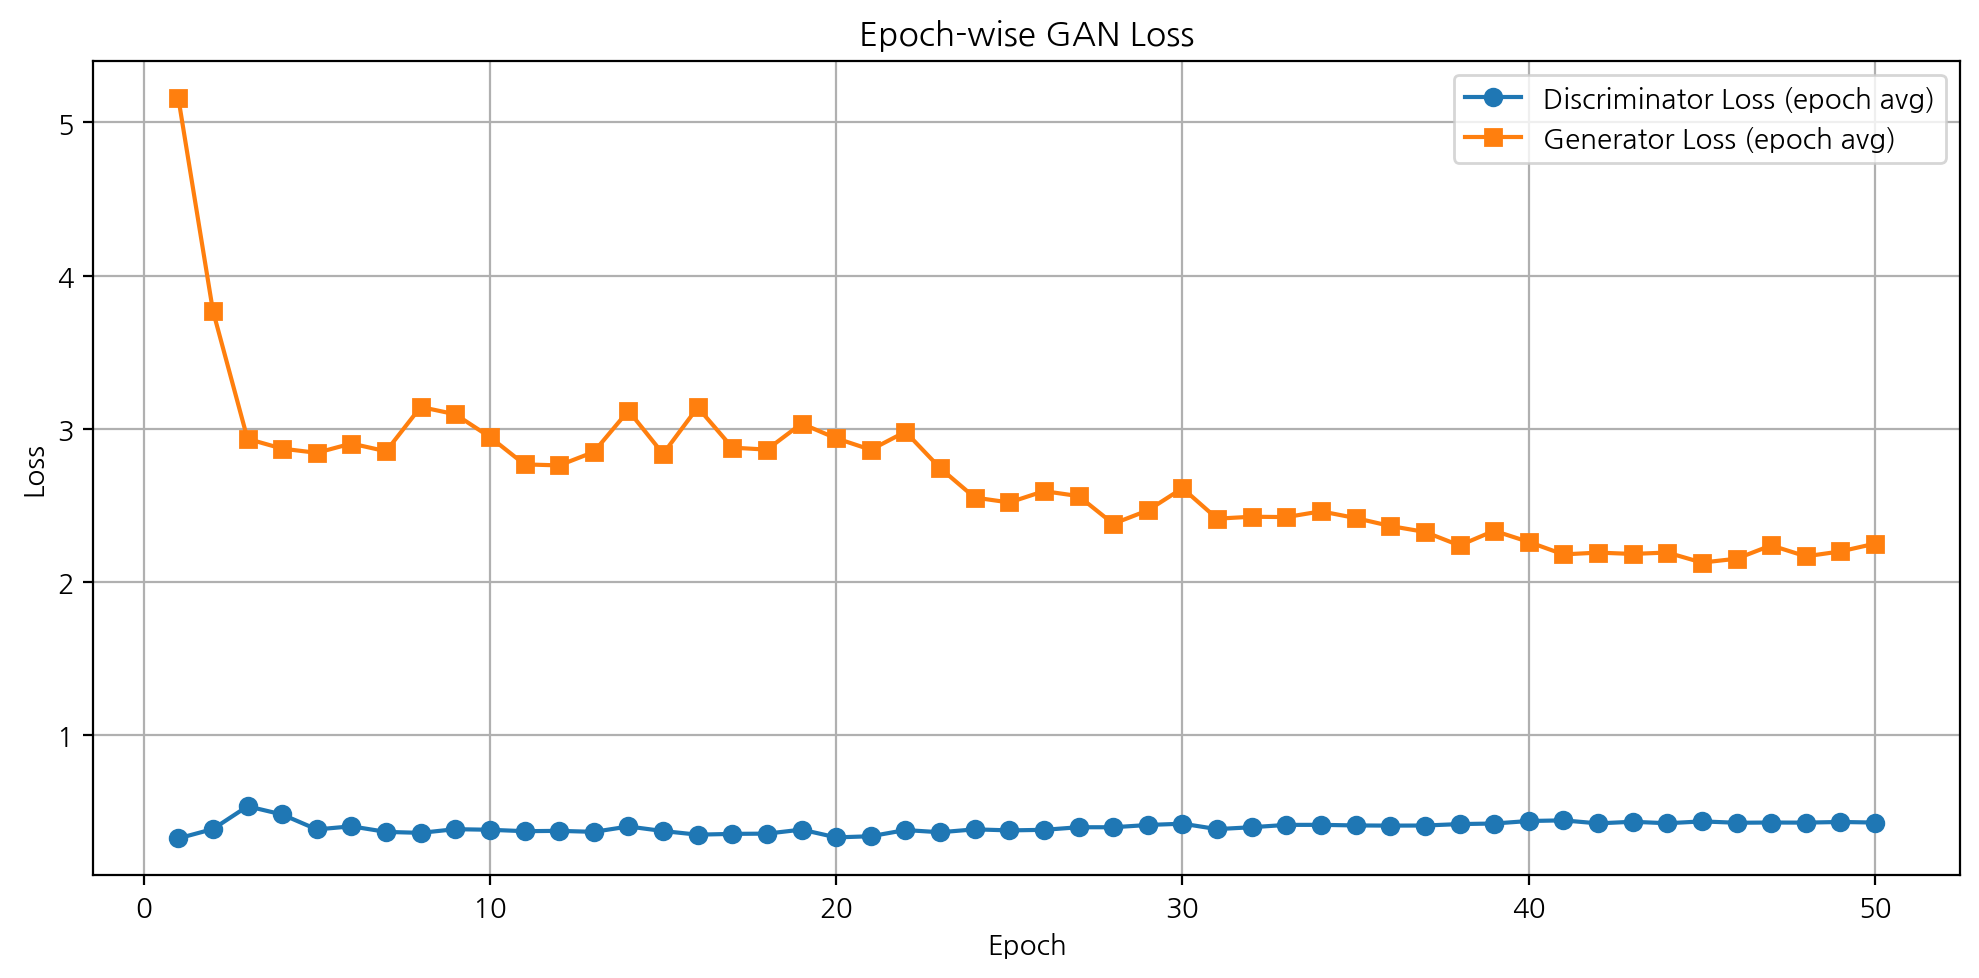

In [ ]:
# -------------------- 9. 손실값 데이터 시각화 --------------------
# 에폭 평균 손실값을 시각화하는 함수 정의
def plot_epoch_losses(d_losses, g_losses):
    plt.figure(figsize=(10, 5))

    # 에폭 인덱스를 1부터 시작하도록 수정
    epochs = range(1, len(d_losses) + 1)
    # 에폭별 판별자 손실값 그래프
    plt.plot(epochs, d_losses, label='Discriminator Loss (epoch avg)', marker='o')
    # 에폭별 생성자 손실값 그래프
    plt.plot(epochs, g_losses, label='Generator Loss (epoch avg)', marker='s')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch-wise GAN Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 실제 손실값 리스트를 받아 그래프 출력
plot_epoch_losses(callback.epoch_d_losses, callback.epoch_g_losses)

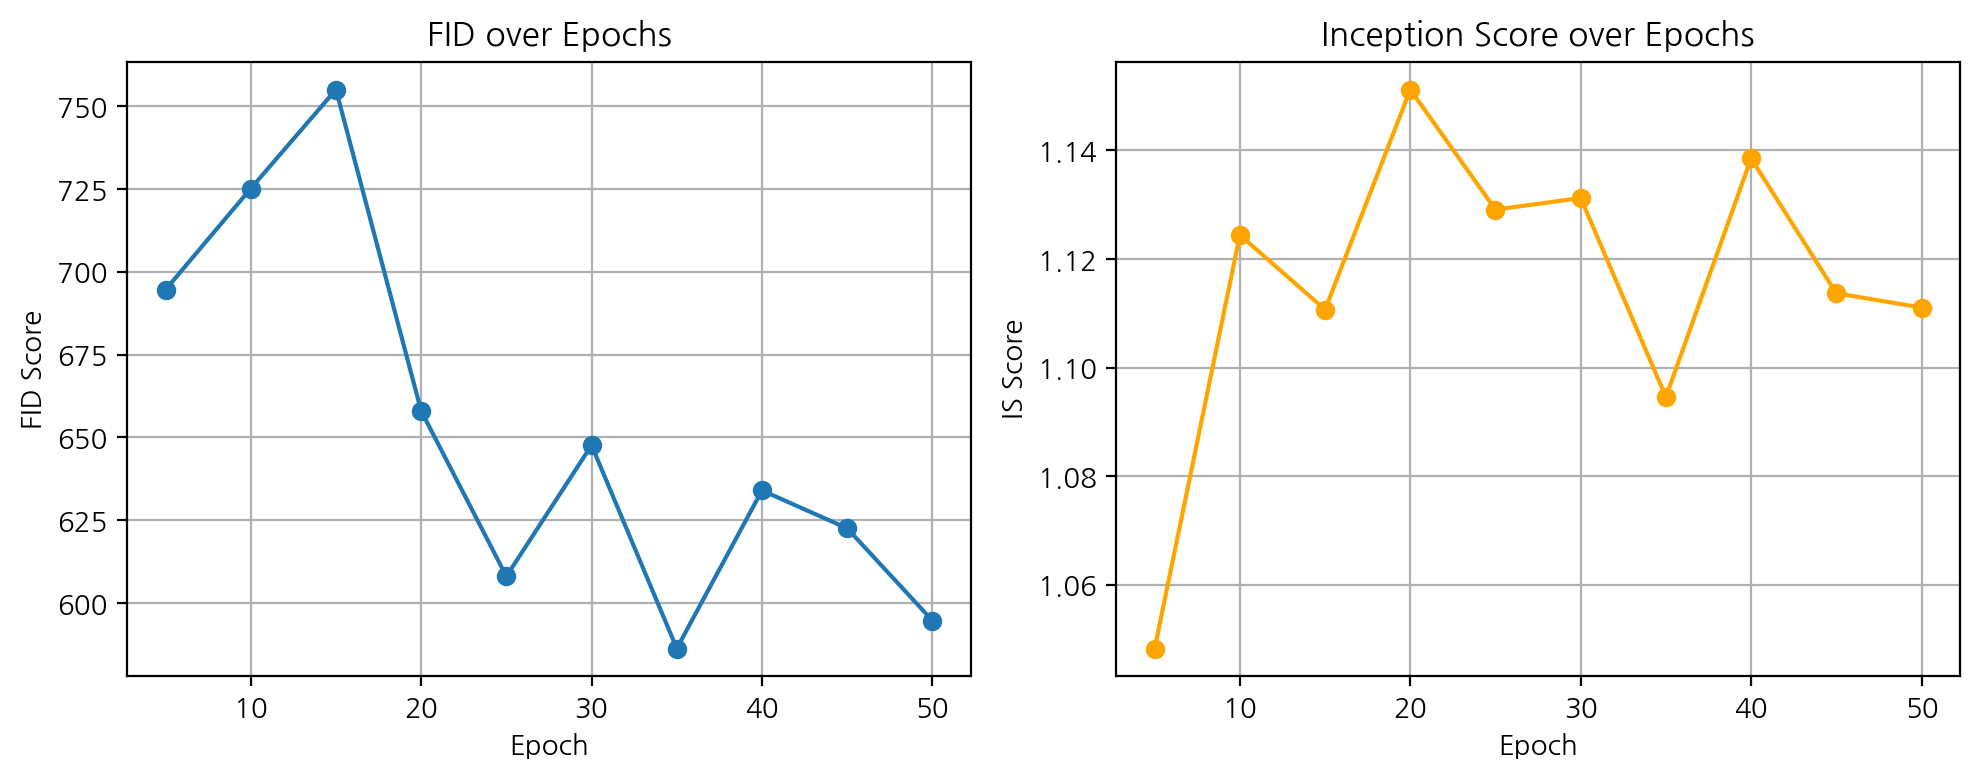

In [ ]:
# -------------------- 10. 평가지표 FID / IS 데이터 시각화 --------------------
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(5, 5 * len(callback.fid_scores) + 1, 5), callback.fid_scores, marker='o')
plt.title("FID over Epochs")
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(5, 5 * len(callback.is_scores) + 1, 5), callback.is_scores, marker='o', color='orange')
plt.title("Inception Score over Epochs")
plt.xlabel("Epoch")
plt.ylabel("IS Score")
plt.grid(True)

plt.tight_layout()
plt.show()

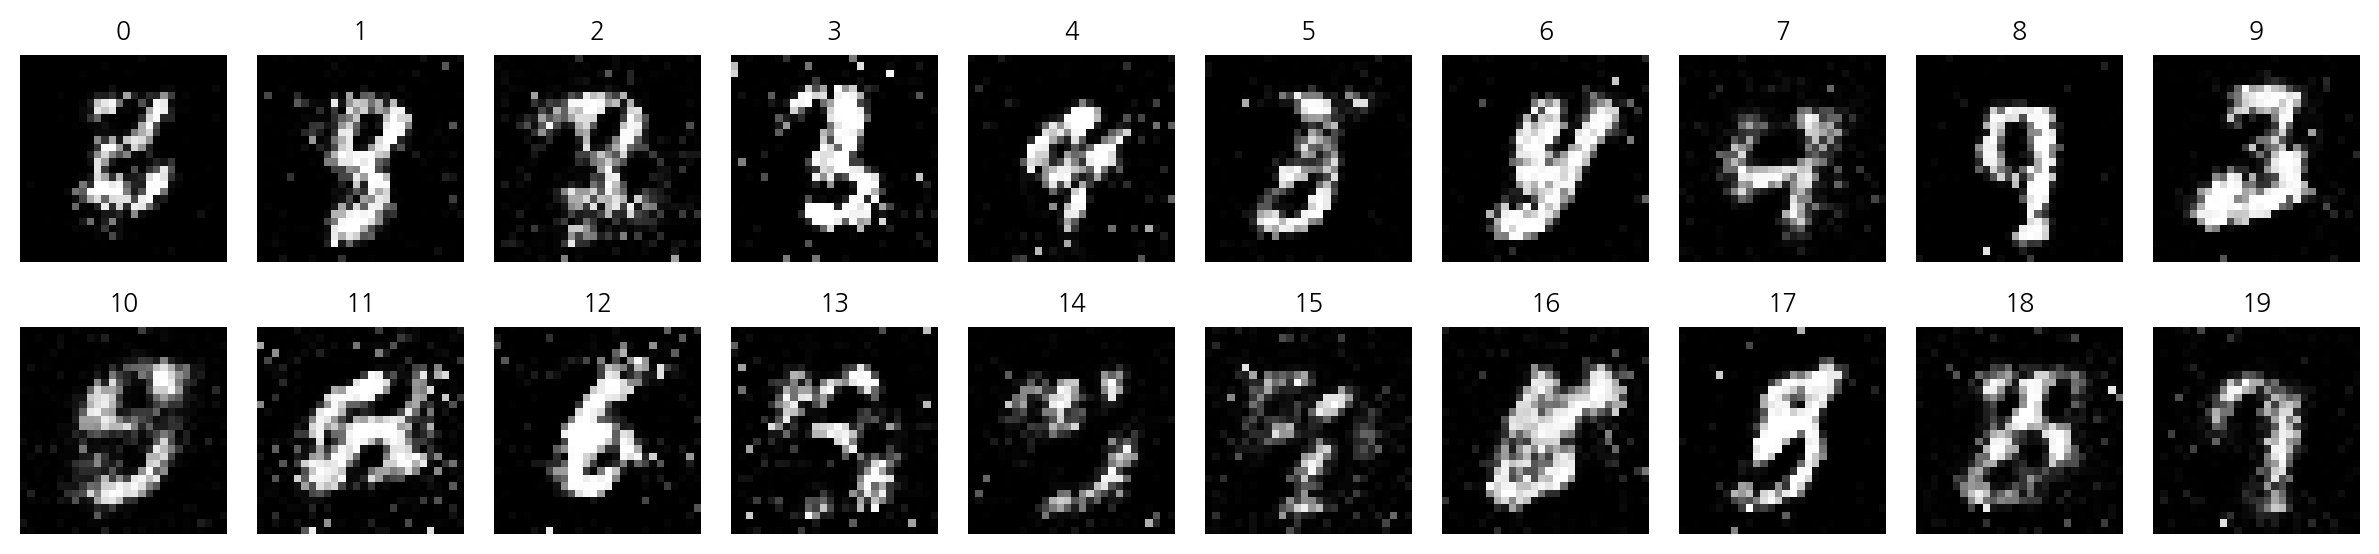

In [ ]:
# -------------------- 11. 최종 이미지 20개 데이터 시각화 --------------------
def show_generated_images(model):
    # 100차원 랜덤 노이즈 20개 생성
    seed = tf.random.normal([20, 100])

    # 생성자를 통해 이미지 생성
    predictions = model(seed, training=False)
        # [-1, 1] 범위를 [0, 1]로 정규화 (시각화를 위해)
    predictions = (predictions + 1.0) / 2.0

    # 2행 10열 subplot 구성 (총 20개 이미지 모두 표시)
    fig = plt.figure(figsize=(12, 3))
    for i in range(20):
        # subplot 배치: 2행 10열, 인덱스는 1부터 시작
        plt.subplot(2, 10, i+1)
        # 이미지 출력 (28x28 흑백 이미지)
        plt.imshow(predictions[i].numpy().reshape(28, 28), cmap='gray')
        # 인덱스 번호를 제목으로 표시
        plt.title(str(i), fontsize=9)
        # 축 눈금 제거
        plt.axis('off')

    # subplot 레이아웃 간격 자동 조절
    plt.tight_layout()
    # 그래프 출력
    plt.show()

# 최종 이미지 시각화 함수 호출
show_generated_images(generator)

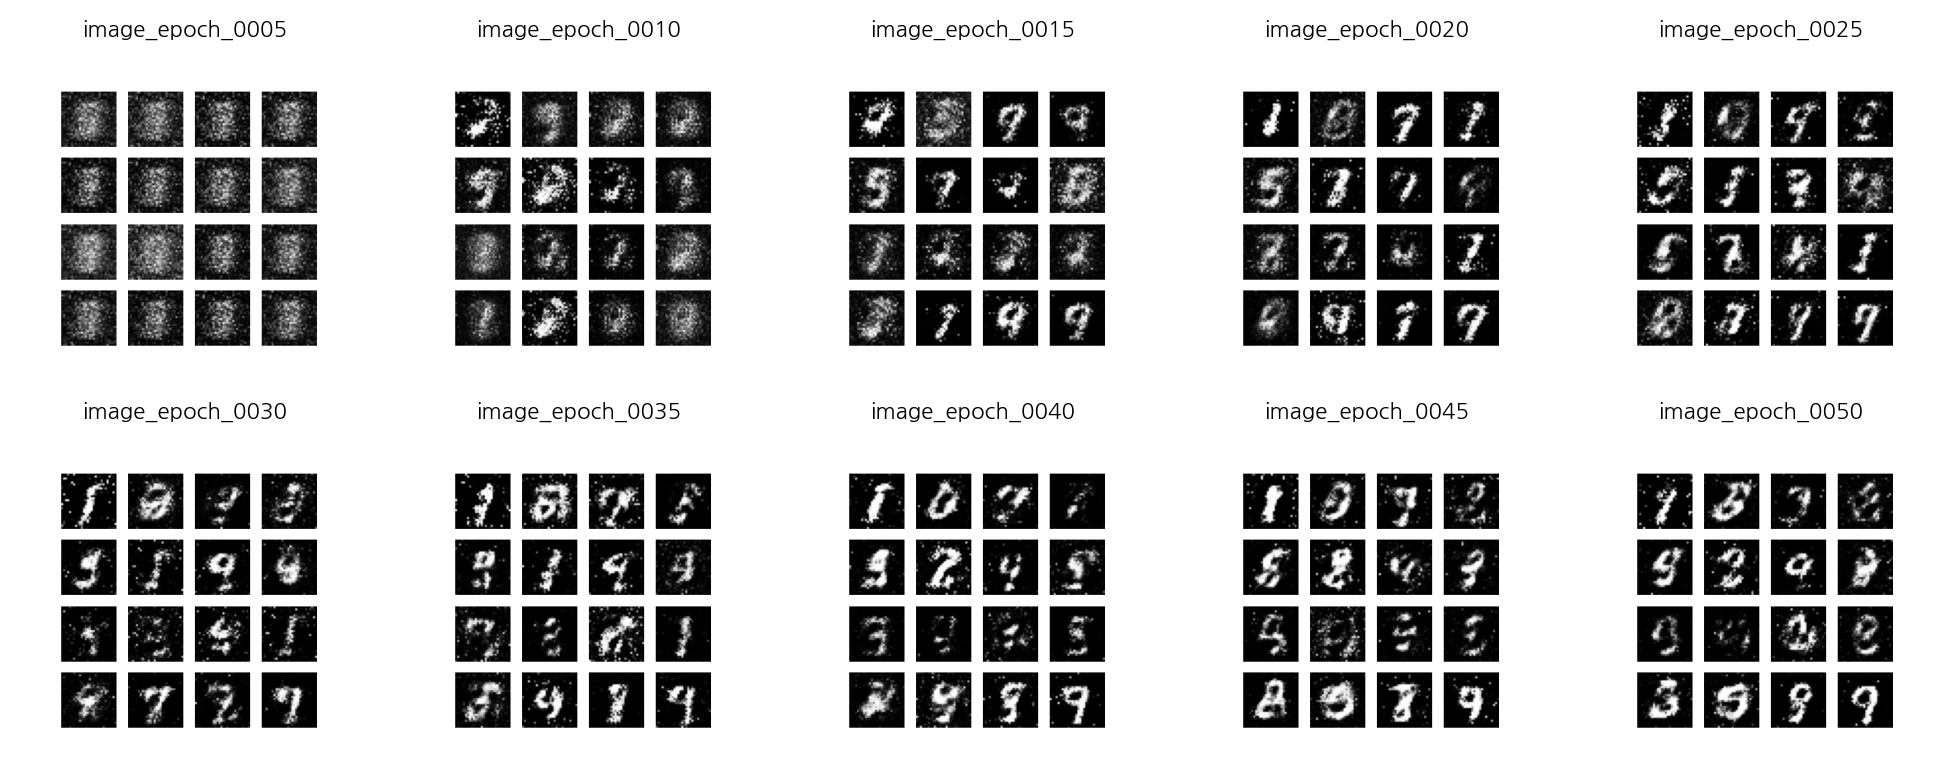

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# -------------------- 12. 저장된 이미지 파일 순차 출력 함수 --------------------
def show_saved_generated_images(folder='generated', cols=5):
    """
    지정된 폴더에 저장된 이미지들을 epoch 순서대로 불러와 출력.

    Args:
        folder (str): 이미지가 저장된 폴더명
        cols (int): 가로에 출력할 이미지 수
    """
    # 파일명 정렬
    files = sorted(
        [f for f in os.listdir(folder) if f.endswith('.png')],
        key=lambda x: int(x.split('_')[-1].split('.')[0])
    )

    # 이미지 개수 및 행 계산
    num_images = len(files)
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(cols * 2, rows * 2))

    for i, filename in enumerate(files):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(filename.split('.')[0], fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_saved_generated_images()

## 종료